In [2]:
import _dunsros as DR

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from tqdm import tqdm
import sklearn.metrics as skm

from kan import *
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics as tm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
# условно константы
k_og = 178                      #газовый фактор м.**3/ст.м.**3
bo = 1.197                      #объемный коэффициент нефти
bw = 1                          #объемный коэффициент воды
bg = 9.1 * 1e-3                 #объемный коэффициент газа
rhow = 1 * 1e3                  #плотность воды
mug = 0.016 * 1e-3              #вязкость газа

# условно переменные
T = 50                          #температура гр.Ц.
d = 0.154                       #диаметр трубы
theta = 90                      #угол наклона скважины
q0 = 1000                       #дебит нефти н.у.
qg0 = 1 * 1e3                   #дебит газа н.у.
rs = 5                          #газовый фактор — коэффициент растворимости газа в нефти (конденсации) или коэффициент выделения газа из нефти (выкипания)
rho0 = 800                      #плотность нефти
rhog = 700                      #плотность газа
muo = 0.97 * 1e-3               #вязкость нефти
epsilon = 18.288 * 1e-6         #шероховатость стенки трубы
sigmao = 8.41 * 1e-3            #коэффициент поверхностного натяжения нефти
# wc = 1 - qg0 / q0 / k_og        #коэффициент обводненности
wc = 0.99
p = 100                         #давление (где?)



# расчетные величины (кроме обводненности, которую удобно использовать как входную переменную)
qo = q0 * (1 - wc) * bo                                 #объем нефти в пластовых условиях
ql = ((1 - wc) * bo + wc * bw) * qo                     #объем жидкости в пластовых условиях
qg = (qg0 - q0 * rs * (1 - wc)) * bg                    #объем газа в пластовых условиях
rho_lrc = rho0 * (1 - wc) / bo + rhow * wc / bw         #плотность жидкой фазы
rho_grc = rhog / rs                                     #плотность газа

delta_qg = 1000

sec_p_day = 24 * 60 * 60                                #переведем все в систему СИ
ql = ql / sec_p_day
qg = (qo * rs * bg * (1 - wc) + delta_qg)  / sec_p_day

args_params = {
        "d": d,                         #диаметр в метрах
        "theta_deg": theta,             #угол
        "ql_rc_m3day": ql,              #дебит жидкости
        "qg_rc_m3day": qg,              #расход газа
        "rho_lrc_kgm3": rho_lrc,        #плотность жидкой фазы
        "rho_grc_kgm3": rho_grc,        #плотность газа
        "p": p,                         #давление (где?)
        "T" : T,                        #температура смеси
        "wc": wc,                       #коэффициент заводнения
        "sigmao": sigmao,               #коэффициент поверхностного натяжения нефти
        "muo": muo,                     #вязкость нефти
}

calibr_C_grav = 1                       #коэффициент калибровки гравитационной компоненты градиента
calibr_C_fric = 1                       #коэффициент калибровки фрикционной компоненты градиента

args_grav_grad = {
        "theta_deg": theta,
        "c_calibr_grav": calibr_C_grav,
}

args_fric_grad = {
        "eps_m": epsilon,
        "mug_rc_cp": mug,
        "c_calibr_fric": calibr_C_fric,
        "rho_lrc_kgm3": rho_lrc,
        "rho_grc_kgm3": rho_grc,
        "T" : T,
        "wc": wc,
        "sigmao": sigmao,
        "muo" : muo,
}

In [473]:
qo /sec_p_day / ql, ql / qg

(0.9980338732696588, 0.011993515579116437)

In [474]:
# протестируем работоспособность класса DunsRos()
dr_corr = DR.DunsRos()
dr_corr.calc_params(**args_params)  #класс подразумевает предварительный рассчет параметров данным методом, иначе работать не будет
dr_corr.calc_grav(**args_grav_grad) + dr_corr.calc_fric(**args_fric_grad), dr_corr.calc_grav(**args_grav_grad), dr_corr.calc_fric(**args_fric_grad)

(5929.930112992178, 5929.838640256922, 0.09147273525571284)

In [475]:
dr_corr.hl, dr_corr.ll, dr_corr.hl > dr_corr.ll

(0.542170869852323, 0.011851375917416931, True)

In [3]:
# создадим функцию для вычисления градиента
def calc_DP_DZ(
        T: float,                       #температура смеси
        d: float,                       #диаметр в метрах
        theta: float,                   #угол
        q0: float,                        
        delta_qg: float,
        rs: float,                        
        rho0: float,                    #плотность нефти
        rhog: float,                    #плотность газа
        muo: float,                       
        epsilon : float,                #шероховатость стенки трубы
        sigmao: float,                  #коэффициент поверхностного натяжения нефти
        wc: float,                      #коэффициент заводнени
        p: float,
):
    
    mug = 0.016 * 1e-3                                      #вязкость газа
    qo = q0 * (1 - wc) * bo                                 #объем нефти в пластовых условиях
    ql = ((1 - wc) * bo + wc * bw) * qo                     #объем жидкости в пластовых условиях
    qg = qo * rs * bg * (1 - wc) + delta_qg                 #объем газа в пластовых условиях
    rho_lrc = rho0 * (1 - wc) / bo + rhow * wc / bw         #плотность жидкой фазы
    rho_grc = rhog / rs                                     #плотность газа (?) 
    
    sec_p_day = 24 * 60 * 60                                #переведем все в систему СИ
    ql = ql / sec_p_day
    qg = qg  / sec_p_day
    
    args_params = {
        "d": d,                         #диаметр в метрах
        "theta_deg": theta,             #угол
        "ql_rc_m3day": ql,              #дебит жидкости
        "qg_rc_m3day": qg,              #расход газа
        "rho_lrc_kgm3": rho_lrc,        #плотность жидкой фазы
        "rho_grc_kgm3": rho_grc,        #плотность газа
        "p": p,                         #давление (где?)
        "T" : T,                        #температура смеси
        "wc": wc,                       #коэффициент заводнения
        "sigmao": sigmao,               #коэффициент поверхностного натяжения нефти
        "muo": muo,                     #вязкость нефти
        }
    
    calibr_C_grav = 1                   #коэффициент калибровки гравитационной компоненты градиента
    calibr_C_fric = 1                   #коэффициент калибровки фрикционной компоненты градиента
    
    args_grav_grad = {
        "theta_deg": theta,
        "c_calibr_grav": calibr_C_grav,
        }
    
    args_fric_grad = {
        "eps_m": epsilon,
        "mug_rc_cp": mug,
        "c_calibr_fric": calibr_C_fric,
        "rho_lrc_kgm3": rho_lrc,
        "rho_grc_kgm3": rho_grc,
        "T" : T,
        "wc": wc,
        "sigmao": sigmao,
        "muo" : muo,
        }
    
    dr_corr = DR.DunsRos()
    dr_corr.calc_params(**args_params)
    mode = dr_corr.fp
    hl = dr_corr.hl
    ll = dr_corr.ll
    grav = dr_corr.calc_grav(**args_grav_grad)
    fric = dr_corr.calc_fric(**args_fric_grad)
    return mode, grav, fric, hl, ll


In [477]:
T = 10                          #температура гр.Ц.
d = 0.154                       #диаметр трубы
theta = 90                      #угол наклона скважины
q0 = 1000                       #дебит нефти н.у.
delta_qg = 1000
rs = 5                          #газовый фактор — коэффициент растворимости газа в нефти (конденсации) или коэффициент выделения газа из нефти (выкипания)
rho0 = 800                      #плотность нефти
rhog = 700                      #плотность газа
muo = 0.97 * 1e-3               #вязкость нефти
epsilon = 18.288 * 1e-6         #шероховатость стенки трубы
sigmao = 8.41 * 1e-3            #коэффициент поверхностного натяжения нефти
wc = 0.009

calc_DP_DZ(T, d, theta, q0, delta_qg, rs, rho0, rhog, muo, epsilon, sigmao, wc, 1)

(0,
 4690.72431867794,
 36.53531214518597,
 0.6364447961138429,
 0.5737108503710783)

In [22]:
count = 5
count_min = 3

# Набираем диапазоны выбранных переменных для перебора. Диапазоны короткие, т.к. при переборе будет count**13 значений (у нас 13 входных параметров)
T = np.linspace(10, 100, count_min)                    #температура гр.Ц.
d = np.linspace(0.11, 0.32, count)                     #диаметры труб
theta = np.linspace(10, 90, count_min)                  #уголы наклона
q0 = np.linspace(5, 1000, count)                       #дебит нефти п.у. м**3/с
delta_qg = np.linspace(0, 1000, count)                 #дельта к дебиту нефти, чтобы не получить отрицательные значения по расходу газа (для корректного рассчета коррелляции)
rs = np.linspace(5, 30, count)                         #коэффициент растворимости газа в нефти (конденсации) или коэффициент выделения газа из нефти (выкипания)
rho0 = np.linspace(780, 900, count_min)                #плотность нефти
rhog = np.linspace(700, 1300, count)                   #плотность газа
muo = np.linspace(1.5 * 1e-3, 150 * 1e-3, count)       #вязкость нефти
epsilon = np.linspace(15 * 1e-6, 300 * 1e-6, count)    #шероховатость стенки трубы
sigmao = np.linspace(10 * 1e-3, 30 * 1e-3, count_min)  #коэффициент поверхностного натяжения нефти
wc = np.linspace(0.05,0.98,count)                      #коэффициент обводненности
p = np.linspace(10,100,count)                          #давление (где?)

In [69]:
iters_count = 0
for T_i, d_i, theta_i, q0_i, delta_qg_i, rs_i, rho0_i, rhog_i, muo_i, epsilon_i, sigmao_i, wc_i in itertools.product(T, d, theta, q0, delta_qg, rs, rho0, rhog, muo, epsilon, sigmao, wc): iters_count += 1
iters_count

31640625

Нагенерим теперь датасет для обучения

In [24]:
iters_count = 31640625
data_dict = []
data_fp_2_3_dict = []
with tqdm(total=iters_count) as pbar:
    for T_i, d_i, theta_i, q0_i, delta_qg_i, rs_i, rho0_i, rhog_i, muo_i, epsilon_i, sigmao_i, wc_i in itertools.product(T, d, theta, q0, delta_qg, rs, rho0, rhog, muo, epsilon, sigmao, wc):
        pbar.update(1)
        mode, grav, fric, hl, ll = calc_DP_DZ(T_i, d_i, theta_i, q0_i, delta_qg_i, rs_i, rho0_i, rhog_i, muo_i, epsilon_i, sigmao_i, wc_i, 1)
        if (grav > 0 and fric > 0 and hl > ll) and (mode == 0 or mode == 1):
            DP_DZ = grav + fric
            data_dict.append({'T' : T_i, 
                              'd' : d_i,
                              'theta' : theta_i,
                              'q0' : q0_i,
                              'delta_qg' : delta_qg_i,
                              'rs' : rs_i,
                              'rho0' : rho0_i,
                              'rhog' : rhog_i,
                              'muo' : muo_i,
                              'epsilon' : epsilon_i,
                              'sigmao' : sigmao_i,
                              'wc' : wc_i,
                              'DP_DZ' : DP_DZ,
                              'mode': mode,
                              })
        elif (grav > 0 and fric > 0 and hl > ll) and (mode == 2 or mode == 3):
            for p_i in p:
                mode, grav, fric, hl, ll = calc_DP_DZ(T_i, d_i, theta_i, q0_i, delta_qg_i, rs_i, rho0_i, rhog_i, muo_i, epsilon_i, sigmao_i, wc_i, p_i)
                DP_DZ = grav + fric
                data_fp_2_3_dict.append({'T' : T_i, 
                                        'd' : d_i,
                                        'theta' : theta_i,
                                        'q0' : q0_i,
                                        'delta_qg' : delta_qg_i,
                                        'rs' : rs_i,
                                        'rho0' : rho0_i,
                                        'rhog' : rhog_i,
                                        'muo' : muo_i,
                                        'epsilon' : epsilon_i,
                                        'sigmao' : sigmao_i,
                                        'wc' : wc_i,
                                        'p' : p_i,                                        
                                        'DP_DZ' : DP_DZ,
                                        'mode': mode,
                                        })


100%|██████████| 31640625/31640625 [1:55:29<00:00, 4565.82it/s]  


Теперь нужно нагенерить данных для валидаци. Их мы будем вычислять для промежуточных значений аргументов.

In [ ]:
count = 2

# Набираем диапазоны выбранных переменных для перебора. Диапазоны короткие, т.к. при переборе будет count**13 значений (у нас 13 входных параметров)
T = 60                    #температура гр.Ц.
d = np.linspace(0.15, 0.25, count)                     #диаметры труб
theta = 80                  #уголы наклона
q0 = np.linspace(100, 700, count)                       #дебит нефти п.у. м**3/с
delta_qg = np.linspace(0, 1000, count)                 #дельта к дебиту нефти, чтобы не получить отрицательные значения по расходу газа (для корректного рассчета коррелляции)
rs = np.linspace(5, 30, count)                         #коэффициент растворимости газа в нефти (конденсации) или коэффициент выделения газа из нефти (выкипания)
rho0 = np.linspace(780, 900, count_min)                #плотность нефти
rhog = np.linspace(700, 1300, count)                   #плотность газа
muo = np.linspace(1.5 * 1e-3, 150 * 1e-3, count)       #вязкость нефти
epsilon = np.linspace(15 * 1e-6, 300 * 1e-6, count)    #шероховатость стенки трубы
sigmao = np.linspace(10 * 1e-3, 30 * 1e-3, count_min)  #коэффициент поверхностного натяжения нефти
wc = np.linspace(0.05,0.98,count)                      #коэффициент обводненности
p = np.linspace(10,100,count)                          #давление (где?)

In [ ]:
data = pd.DataFrame(data_dict)
# data_2_3 = pd.DataFrame(data_fp_2_3_dict)
data.to_csv('data.csv')
# data_2_3.to_csv('data_2_3.csv')

In [27]:
data.head(10)

,T,d,theta,q0,delta_qg,rs,rho0,rhog,muo,epsilon,sigmao,wc,DP_DZ,mode
0,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.01,0.0500,1138.069945,0
1,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.01,0.2825,1276.746966,0
2,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.01,0.5150,1415.209229,0
3,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.01,0.7475,1553.510025,0
4,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.01,0.9800,1691.618803,0
5,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.02,0.0500,1138.267172,0
6,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.02,0.2825,1276.797217,0
7,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.02,0.5150,1415.221027,0
8,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.02,0.7475,1553.511426,0
9,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.02,0.9800,1691.618804,0


In [28]:
data['DP_DZ'].min(), data['DP_DZ'].max()

(427.0378927128137, 9761.318266811797)

In [29]:
data[data['mode'] == 1].count()['mode'], data[data['mode'] == 0].count()['mode']

(9365925, 21388200)

In [10]:
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30754125 entries, 0 to 30754124
Data columns (total 15 columns):
 #   Column      Non-Null Count     Dtype  
---  ------      --------------     -----  
 0   Unnamed: 0  30754125 non-null  int64  
 1   T           30754125 non-null  float64
 2   d           30754125 non-null  float64
 3   theta       30754125 non-null  float64
 4   q0          30754125 non-null  float64
 5   delta_qg    30754125 non-null  float64
 6   rs          30754125 non-null  float64
 7   rho0        30754125 non-null  float64
 8   rhog        30754125 non-null  float64
 9   muo         30754125 non-null  float64
 10  epsilon     30754125 non-null  float64
 11  sigmao      30754125 non-null  float64
 12  wc          30754125 non-null  float64
 13  DP_DZ       30754125 non-null  float64
 14  mode        30754125 non-null  int64  
dtypes: float64(13), int64(2)
memory usage: 3.4 GB


In [9]:
len(data.index)-len(data.drop_duplicates().index)

0

In [6]:
data.isna().sum()

T           0
d           0
theta       0
q0          0
delta_qg    0
rs          0
rho0        0
rhog        0
muo         0
epsilon     0
sigmao      0
wc          0
DP_DZ       0
dtype: int64

In [33]:
data[data['DP_DZ'] == 0].count()['DP_DZ']

0

Попробуем разобраться, почему мы наблюдаем только пузырьковый и пробковый режимы. 
Для этого нужно посмотреть при каких параметрах n_gv > n_tr_m
где n_gv = self.vsg * (rho_lrc_kgm3 / (9.81 * sigma_l_nm)) ** 0.25, а n_tr_m = 75 + 84 * n_lv**0.75, где в свою очередь
self.vsl * (rho_lrc_kgm3 / (9.81 * sigma_l_nm)) ** 0.25,
а обе vs* прямопропорциональны дебиту жидкости (газа) и обратнопропорциональны площади сечения трубы

In [280]:
d = 0.011                         #диаметр в метрах
theta_deg = 90             #угол
ql_rc_m3day = 80 / sec_p_day              #дебит жидкости
qg_rc_m3day = 1000 / sec_p_day              #расход газа
rho_lrc_kgm3 = 900        #плотность жидкой фазы
rho_grc_kgm3 = 140        #плотность газа
p = 1                         #давление (где?)
sigmao = 0.00841               #коэффициент поверхностного натяжения нефти
muo = 0.97 * 1e-3                     #вязкость нефти
T = 100
wc = 0.9



args_params = {
        "d": d,                         #диаметр в метрах
        "theta_deg": theta_deg,             #угол
        "ql_rc_m3day": ql_rc_m3day,              #дебит жидкости
        "qg_rc_m3day": qg_rc_m3day,              #расход газа
        "rho_lrc_kgm3": rho_lrc_kgm3,        #плотность жидкой фазы
        "rho_grc_kgm3": rho_grc_kgm3,        #плотность газа
        "p": p,                         #давление (где?)
        "T" : T,                        #температура смеси
        "wc": wc,                       #коэффициент заводнения
        "sigmao": sigmao,               #коэффициент поверхностного натяжения нефти
        "muo": muo,                     #вязкость нефти
        }

dr_corr = DR.DunsRos()
dr_corr.calc_params(**args_params)


In [277]:
n_gv = dr_corr.vsg * (rho_lrc / (9.81 * (sigmao * (1 - wc) + dr_corr.dr_const["sigmaw"](T) * wc))) ** 0.25
n_gv, dr_corr.vsg

(802.6655329082911, 121.7898248331002)

In [278]:
n_tr_m = 75 + 84 * ((dr_corr.vsl * (rho_lrc / (9.81 * (sigmao * (1 - wc) + dr_corr.dr_const["sigmaw"](T) * wc)))) ** 0.25) ** 0.75
n_tr_m, dr_corr.vsl

(604.4847163583545, 9.743185986648017)

Таким образом эмульсионный режим возможен в данной корреляции либо в газовой скважине(но при этом градиент получается отрицательным), 
либо в при малых диаметрах трубы (~10 см), но также при налиичии большого количества попутного газа. Эти цифры нереалистичны, поэтому опустим. Окей, вернемся к нашим данным.

In [97]:
data = pd.read_csv('data.csv')
data.drop({'Unnamed: 0', 'mode'}, axis=1, inplace=True)

In [98]:
labels = pd.DataFrame(data['DP_DZ'])

In [99]:
data.drop('DP_DZ', axis=1, inplace=True)

In [100]:
data

,T,d,theta,q0,delta_qg,rs,rho0,rhog,muo,epsilon,sigmao,wc
0,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.01,0.0500
1,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.01,0.2825
2,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.01,0.5150
3,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.01,0.7475
4,10.0,0.11,10.0,5.0,0.0,5.0,780.0,700.0,0.0015,0.000015,0.01,0.9800
...,...,...,...,...,...,...,...,...,...,...,...,...
30754120,100.0,0.32,90.0,1000.0,1000.0,30.0,900.0,1300.0,0.1500,0.000300,0.03,0.0500
30754121,100.0,0.32,90.0,1000.0,1000.0,30.0,900.0,1300.0,0.1500,0.000300,0.03,0.2825
30754122,100.0,0.32,90.0,1000.0,1000.0,30.0,900.0,1300.0,0.1500,0.000300,0.03,0.5150
30754123,100.0,0.32,90.0,1000.0,1000.0,30.0,900.0,1300.0,0.1500,0.000300,0.03,0.7475


In [101]:
labels

,DP_DZ
0,1138.069945
1,1276.746966
2,1415.209229
3,1553.510025
4,1691.618803
...,...
30754120,5181.882493
30754121,5469.962419
30754122,5684.114433
30754123,5832.330066


Было бы крайне недурно нормализовать признаки, потому что сейчас они отличаются на несколько порядков

In [14]:
data['T'] = data['T'] * 1e1
data['d'] = data['d'] * 1e4
data['theta'] = data['theta'] * 1e1
data['rs'] = data['rs'] * 1e2
data['muo'] = data['muo'] * 1e4
data['epsilon'] = data['epsilon'] * 1e7
data['sigmao'] = data['sigmao'] * 1e5
data['wc'] = data['wc'] * 1e3

In [18]:
data

,T,d,theta,q0,delta_qg,rs,rho0,rhog,muo,epsilon,sigmao,wc
0,100.0,1100.0,100.0,5.0,0.0,500.0,780.0,700.0,15.0,150.0,1000.0,50.0
1,100.0,1100.0,100.0,5.0,0.0,500.0,780.0,700.0,15.0,150.0,1000.0,282.5
2,100.0,1100.0,100.0,5.0,0.0,500.0,780.0,700.0,15.0,150.0,1000.0,515.0
3,100.0,1100.0,100.0,5.0,0.0,500.0,780.0,700.0,15.0,150.0,1000.0,747.5
4,100.0,1100.0,100.0,5.0,0.0,500.0,780.0,700.0,15.0,150.0,1000.0,980.0
...,...,...,...,...,...,...,...,...,...,...,...,...
30754120,1000.0,3200.0,900.0,1000.0,1000.0,3000.0,900.0,1300.0,1500.0,3000.0,3000.0,50.0
30754121,1000.0,3200.0,900.0,1000.0,1000.0,3000.0,900.0,1300.0,1500.0,3000.0,3000.0,282.5
30754122,1000.0,3200.0,900.0,1000.0,1000.0,3000.0,900.0,1300.0,1500.0,3000.0,3000.0,515.0
30754123,1000.0,3200.0,900.0,1000.0,1000.0,3000.0,900.0,1300.0,1500.0,3000.0,3000.0,747.5


In [ ]:
# T = torch.tensor(data['T'].values, requires_grad=True)
# d = torch.tensor(data['d'].values, requires_grad=True)
# theta = torch.tensor(data['theta'].values, requires_grad=True)
# q0 = torch.tensor(data['q0'].values, requires_grad=True)
# delta_qg = torch.tensor(data['delta_qg'].values, requires_grad=True)
# rs = torch.tensor(data['rs'].values, requires_grad=True)
# rho0 = torch.tensor(data['rho0'].values, requires_grad=True)
# rhog = torch.tensor(data['rhog'].values, requires_grad=True)
# muo = torch.tensor(data['muo'].values, requires_grad=True)
# epsilon = torch.tensor(data['epsilon'].values, requires_grad=True)
# wc = torch.tensor(data['wc'].values, requires_grad=True)

In [ ]:
#соберем датасет в формате PyKAN
dataset = create_dataset_from_data(torch.tensor(data.values, dtype=torch.float32), torch.tensor(labels.values, dtype=torch.long))

In [22]:
G = 5
k = 3

"""
Здесь необходимо сказать несолько слов о выбранных ширинах слоев. В соответствии с теоремой К-А для апроксимации ф-ии N-переменных
требуется (2N+1)N одномерных функций. Однако, здесь идет речь не о функциях какого-то конкретного вида, поэтому будет некорректно приближать
нашу многомерную функцию (2N+1)N сплайнами специфичной конфигурации. Даже не смотря на то, что фактически каждый сплайн — это нелинейная
суперпозиция k линейных функций. Кроме того в ряде работ, указывается, что однослойные нейросети в общем (и К-А — в частности) не очень хороши
для аппроксимации многомерных функций. Поэтому я предварительно хочу попробовать аппроксимировать функцию градиента сеткой с 2 слоями шириной
(2N+1)N и N узлов соответственно. Далее будем "плясать" от резуальтатов. 
"""

W = len(data.columns)
width = [W, ((2 * W + 1) * W), W, 1]
model = KAN(width=width, device=device)

checkpoint directory created: ./model
saving model version 0.0


In [ ]:
model.fit(dataset, opt="SGD", lr=0.001, steps=20, update_grid=False, singularity_avoiding=True)

description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

: 

Модель крашится при любых параметрах. Попробуем что-нибудь поменять. Например, размероность модели.

Отфильтровать dataframe по словарю у меня не вышло...

In [102]:
param_str = 'T == 55 & d == 0.215 & theta == 90 & q0 == 253.75 & delta_qg == 250 & rs == 17.5 & rho0 == 840. & rhog == 700. & muo == 0.07575 & epsilon == 0.000015 & sigmao > 0.01 & sigmao < 0.03'

Почему-то фильтр по sigmao == 0.02 выдает пустой dataframe. Мистика.

In [118]:
data_small = data.query(param_str)
data_small = pd.DataFrame(data_small['wc'] * 1e3)
data_small

,wc
15898055,50.0
15898056,282.5
15898057,515.0
15898058,747.5
15898059,980.0


In [114]:
labels_small = labels[labels.index.isin(list(data_small.index.values))]
labels_small

,DP_DZ
15898055,5345.992180
15898056,5824.309893
15898057,6251.537246
15898058,6620.132121
15898059,6928.509104


In [119]:
tensor_data = torch.tensor(data_small.values, dtype=torch.float32)
tensor_labels = torch.tensor(labels_small.values, dtype=torch.long)

In [ ]:
dataset = create_dataset_from_data(tensor_data, tensor_labels)
model = KAN([1,3,1], grid=4, k=3, seed=0)

checkpoint directory created: ./model
saving model version 0.0


In [189]:
model.fit(dataset, steps = 20)

| train_loss: 4.88e-04 | test_loss: 4.52e+03 | reg: 7.86e+01 | : 100%|█| 20/20 [00:01<00:00, 16.70it

saving model version 0.1


{'train_loss': [array(2405.0833, dtype=float32),
  array(472.16888, dtype=float32),
  array(313.1248, dtype=float32),
  array(174.6182, dtype=float32),
  array(65.27563, dtype=float32),
  array(329.73438, dtype=float32),
  array(0.13741215, dtype=float32),
  array(0.00054592, dtype=float32),
  array(0.00054592, dtype=float32),
  array(0.00054592, dtype=float32),
  array(2300.9011, dtype=float32),
  array(548.97394, dtype=float32),
  array(0.00073242, dtype=float32),
  array(0.00073242, dtype=float32),
  array(0.00073242, dtype=float32),
  array(0.00048828, dtype=float32),
  array(0.00048828, dtype=float32),
  array(0.00048828, dtype=float32),
  array(0.00048828, dtype=float32),
  array(0.00048828, dtype=float32)],
 'test_loss': [array(2368.1924, dtype=float32),
  array(393.35156, dtype=float32),
  array(364.98486, dtype=float32),
  array(367.9707, dtype=float32),
  array(153.29297, dtype=float32),
  array(13999.449, dtype=float32),
  array(10737.5, dtype=float32),
  array(10737.523, dt

KAN не работает по-прежнему. Хорошо, хоть не крашится. 
Попробуем все-таки нагенерить датасет размером поболее, но возьмем при этом 2 переменных. Остальные параметры зафиксируем.

In [7]:
count = 9
d = np.linspace(0.05, 0.5, count)
wc = np.linspace(0, 0.99, count)
constants = {'T' : 55,
              'theta' : 90,
              'q0' : 253.75,
              'delta_qg' : 250.,
              'rs' : 17.5,
              'rho0' : 840.,
              'rhog' : 700.,
              'muo' : 0.07575,
              'epsilon' : 0.000015,
              'sigmao' : 0.02,
              'p' : 1
            }
mode, grav, fric, hl, ll = calc_DP_DZ(**constants, wc=0.3, d = 0.2)
grav + fric

5732.444427473592

Нагенерим новый датафрейм

In [8]:
iters_count = count ** 2
data_dict = []
data_fp_2_3_dict = []
with tqdm(total=iters_count) as pbar:
    for d_i, wc_i in itertools.product(d, wc):
        pbar.update(1)
        mode, grav, fric, hl, ll = calc_DP_DZ(**constants, wc = wc_i, d = d_i)
        if (grav > 0 and fric > 0 and hl > ll) and (mode == 0 or mode == 1):
            DP_DZ = grav + fric
            data_dict.append({'d' : d_i,
                              'wc' : wc_i,
                              'DP_DZ' : DP_DZ,
                              'mode': mode,
                              })

100%|██████████| 81/81 [00:00<00:00, 2843.48it/s]


In [9]:
data = pd.DataFrame(data_dict)

In [10]:
data

,d,wc,DP_DZ,mode
0,0.05,0.00000,5218.559872,0
1,0.05,0.12375,5115.157373,0
2,0.05,0.24750,4650.019686,1
3,0.05,0.37125,4444.149860,1
4,0.05,0.49500,4189.899341,1
...,...,...,...,...
76,0.50,0.49500,7745.389304,0
77,0.50,0.61875,8094.844928,0
78,0.50,0.74250,8440.771167,0
79,0.50,0.86625,8782.953737,0


In [77]:
labels_tensor = torch.tensor(np.float32(pd.DataFrame(data['DP_DZ']).values))
data_tensor = torch.tensor(np.float32(pd.DataFrame(data[['d', 'wc']]).values))
dataset = create_dataset_from_data(data_tensor, labels_tensor)

Преобразование в float32 нужно чтобы избежать ошибок в дальнейшем — это глюк PyKAN

In [ ]:
model = KAN([2,5,8,1], grid=5, k=3, seed=0)
model.fit(dataset, steps = 200)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 6.48e-01 | test_loss: 9.79e+01 | reg: 3.18e+02 | : 100%|█| 200/200 [00:18<00:00, 10.68


saving model version 0.1


{'train_loss': [array(2316.8816, dtype=float32),
  array(869.74927, dtype=float32),
  array(679.2965, dtype=float32),
  array(609.75415, dtype=float32),
  array(585.3566, dtype=float32),
  array(332.47156, dtype=float32),
  array(227.2229, dtype=float32),
  array(178.64035, dtype=float32),
  array(125.24476, dtype=float32),
  array(69.52582, dtype=float32),
  array(52.225327, dtype=float32),
  array(42.91168, dtype=float32),
  array(35.902992, dtype=float32),
  array(31.427864, dtype=float32),
  array(29.320732, dtype=float32),
  array(25.520473, dtype=float32),
  array(21.79561, dtype=float32),
  array(20.235815, dtype=float32),
  array(18.000568, dtype=float32),
  array(15.41265, dtype=float32),
  array(13.053596, dtype=float32),
  array(12.329128, dtype=float32),
  array(11.462358, dtype=float32),
  array(10.470761, dtype=float32),
  array(9.744957, dtype=float32),
  array(8.8879595, dtype=float32),
  array(8.588346, dtype=float32),
  array(7.8815727, dtype=float32),
  array(7.26730

In [144]:
model = model.prune_node(threshold=1e-2)

saving model version 0.2


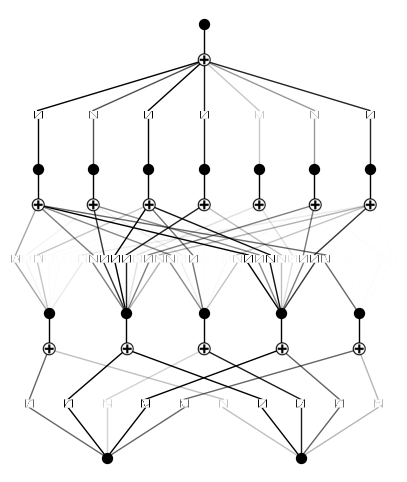

In [145]:
model.plot()

Теперь работает. Попробуем потестить.

In [146]:
test_dataset = [[0.7,0.07],[0.125,0.2], [0.18,0.3], [0.25,0.4], [0.35,0.55], [0.4,0.68], [0.47,0.8]]
test_tensor = torch.tensor(np.float32(test_dataset))

In [175]:
DP_DZ_KAN = model(test_tensor).tolist()

In [178]:
DP_DZ_KAN

[[243.92420959472656],
 [5064.79833984375],
 [5549.89453125],
 [6390.91064453125],
 [7412.962890625],
 [7950.32666015625],
 [8601.78125]]

In [162]:
test_df = pd.DataFrame(test_dataset, columns=['d', 'wc'])
DP_DZ_dict = []
for i in range(len(test_df)):
    mode, grav, fric, hl, ll = calc_DP_DZ(**constants, wc = test_df['wc'][i], d = test_df['d'][i])
    DP_DZ_dict.append(grav + fric)

In [163]:
DP_DZ_dict

[6774.556921850855,
 4960.173674017015,
 5559.216379972291,
 6350.002509378962,
 7380.608566755912,
 7956.017411945444,
 8521.721501053862]

In [188]:
skm.mean_absolute_percentage_error(DP_DZ_dict, DP_DZ_KAN)

0.14395711754197854

Не сказать, чтобы очень хреново, но явно не укладывается в 0.01% ошибки по тех. заданию. Если посчитать ошибку для всех значений кроме первого, то получим:

In [190]:
skm.mean_absolute_percentage_error(DP_DZ_dict[1:], DP_DZ_KAN[1:])

0.00728429181950924

То есть если не брать крайние значения, то оценка укладывается в 1%. 
Предлагается теперь увеличить размерность задачи. Например, до 4.

In [442]:
count = 9
sec_p_day = 24 * 60 * 60   

d = np.linspace(0.05, 0.5, count)
wc = np.linspace(0, 0.99, count)
delta_qg = np.linspace(0, 1000, count) / sec_p_day
q0 = np.linspace(5, 700, count) / sec_p_day


constants = {'T' : 50,
            'rho0' : 840.,
            'rhog' : 700.,
            'muo' : 0.07575,
            'epsilon' : 0.000015,
            'sigmao' : 0.02,
            'theta' : 90,
            'rs' : 20,
            'p' : 1,
            }

iters_count = count ** 4
data_dict = []
with tqdm(total=iters_count) as pbar:
    for d_i, wc_i, delta_qg_i, q0_i in itertools.product(d, wc, delta_qg, q0):
        pbar.update(1)
        mode, grav, fric, hl, ll = calc_DP_DZ(**constants, wc = wc_i, d = d_i, delta_qg = delta_qg_i, q0 = q0_i)
        if (grav > 0 and fric > 0 and hl > ll) and (mode == 0 or mode == 1):
            DP_DZ = grav + fric
            data_dict.append({'d' : d_i,
                              'wc' : wc_i,
                              'delta_qg' : delta_qg_i,
                              'q0' : q0_i,
                              'DP_DZ' : DP_DZ,
                              })

100%|██████████| 6561/6561 [00:01<00:00, 3713.07it/s]


In [443]:
data = pd.DataFrame(data_dict)

In [444]:
data

,d,wc,delta_qg,q0,DP_DZ
0,0.05,0.00,0.0,0.000058,6884.207635
1,0.05,0.00,0.0,0.001063,6884.157399
2,0.05,0.00,0.0,0.002069,6884.107172
3,0.05,0.00,0.0,0.003074,6884.056954
4,0.05,0.00,0.0,0.004080,6884.006742
...,...,...,...,...,...
3414,0.50,0.99,0.0,0.004080,9780.742105
3415,0.50,0.99,0.0,0.005085,9780.742105
3416,0.50,0.99,0.0,0.006091,9780.742105
3417,0.50,0.99,0.0,0.007096,9780.742105


In [445]:
data['delta_qg'] = data['delta_qg'] * 1e2
data['q0'] = data['q0'] * 1e2

In [446]:
data

,d,wc,delta_qg,q0,DP_DZ
0,0.05,0.00,0.0,0.005787,6884.207635
1,0.05,0.00,0.0,0.106337,6884.157399
2,0.05,0.00,0.0,0.206887,6884.107172
3,0.05,0.00,0.0,0.307436,6884.056954
4,0.05,0.00,0.0,0.407986,6884.006742
...,...,...,...,...,...
3414,0.50,0.99,0.0,0.407986,9780.742105
3415,0.50,0.99,0.0,0.508536,9780.742105
3416,0.50,0.99,0.0,0.609086,9780.742105
3417,0.50,0.99,0.0,0.709635,9780.742105


In [447]:
torch.set_default_dtype(torch.float32)
labels_tensor = torch.tensor(np.float32(pd.DataFrame(data['DP_DZ']).values))
data_tensor = torch.tensor(np.float32(pd.DataFrame(data[['d', 'wc', 'delta_qg', 'q0']]).values))
dataset = create_dataset_from_data(data_tensor, labels_tensor)

In [448]:
model = KAN([4,8,16,16,1], grid=10, k=5, seed=0)
model.fit(dataset, steps = 20)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.81e+00 | test_loss: 5.68e+00 | reg: 2.61e+02 | : 100%|█| 20/20 [01:36<00:00,  4.82s/

saving model version 0.1


{'train_loss': [array(625.05365, dtype=float32),
  array(59.76347, dtype=float32),
  array(25.053137, dtype=float32),
  array(15.847317, dtype=float32),
  array(13.126058, dtype=float32),
  array(134.56905, dtype=float32),
  array(30.831303, dtype=float32),
  array(7.182985, dtype=float32),
  array(4.6112113, dtype=float32),
  array(3.0203633, dtype=float32),
  array(36.29572, dtype=float32),
  array(16.246689, dtype=float32),
  array(9.132013, dtype=float32),
  array(5.79318, dtype=float32),
  array(2.2650616, dtype=float32),
  array(69.20208, dtype=float32),
  array(21.815065, dtype=float32),
  array(12.893964, dtype=float32),
  array(7.9226775, dtype=float32),
  array(5.814875, dtype=float32)],
 'test_loss': [array(587.8305, dtype=float32),
  array(55.92846, dtype=float32),
  array(21.672827, dtype=float32),
  array(13.902408, dtype=float32),
  array(12.460163, dtype=float32),
  array(136.68062, dtype=float32),
  array(30.101297, dtype=float32),
  array(7.056503, dtype=float32),
  a

In [431]:
model = KAN([4,8,16,1], grid=10, k=5, seed=0)
model.fit(dataset, steps = 20)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 1.38e+01 | test_loss: 1.36e+01 | reg: 4.66e+02 | : 100%|█| 20/20 [00:56<00:00,  2.82s/

saving model version 0.1


{'train_loss': [array(558.7567, dtype=float32),
  array(541.6901, dtype=float32),
  array(450.74017, dtype=float32),
  array(388.74014, dtype=float32),
  array(324.05386, dtype=float32),
  array(178.02121, dtype=float32),
  array(89.52296, dtype=float32),
  array(61.37217, dtype=float32),
  array(46.60342, dtype=float32),
  array(33.75864, dtype=float32),
  array(178.56017, dtype=float32),
  array(41.869095, dtype=float32),
  array(28.931997, dtype=float32),
  array(25.109236, dtype=float32),
  array(21.42811, dtype=float32),
  array(139.55228, dtype=float32),
  array(40.148537, dtype=float32),
  array(23.184586, dtype=float32),
  array(17.13073, dtype=float32),
  array(13.790725, dtype=float32)],
 'test_loss': [array(555.9233, dtype=float32),
  array(537.3631, dtype=float32),
  array(461.2693, dtype=float32),
  array(394.0785, dtype=float32),
  array(321.53415, dtype=float32),
  array(188.9447, dtype=float32),
  array(93.479706, dtype=float32),
  array(63.610737, dtype=float32),
  arr

In [ ]:
model = KAN([4, 8, 16, 32, 1], grid=10, k=5, seed=0)
model.fit(dataset, steps = 20)

Здесь за 40 шагов лосс разошелся

In [432]:
model = KAN([4, 8, 16, 36, 1], grid=10, k=5, seed=0)
model.fit(dataset, steps = 20)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 5.47e+00 | test_loss: 5.79e+00 | reg: 4.77e+02 | : 100%|█| 20/20 [03:07<00:00,  9.39s/

saving model version 0.1


{'train_loss': [array(8078.6567, dtype=float32),
  array(1362.6766, dtype=float32),
  array(326.53262, dtype=float32),
  array(59.91637, dtype=float32),
  array(23.227701, dtype=float32),
  array(87.57231, dtype=float32),
  array(37.06537, dtype=float32),
  array(20.490881, dtype=float32),
  array(14.017047, dtype=float32),
  array(9.860078, dtype=float32),
  array(23.35391, dtype=float32),
  array(11.575264, dtype=float32),
  array(9.059673, dtype=float32),
  array(7.573085, dtype=float32),
  array(6.6933002, dtype=float32),
  array(27.757954, dtype=float32),
  array(11.114049, dtype=float32),
  array(7.080693, dtype=float32),
  array(6.1363015, dtype=float32),
  array(5.4658227, dtype=float32)],
 'test_loss': [array(8119.3896, dtype=float32),
  array(1445.6167, dtype=float32),
  array(327.8284, dtype=float32),
  array(62.056355, dtype=float32),
  array(25.328768, dtype=float32),
  array(101.93509, dtype=float32),
  array(37.97333, dtype=float32),
  array(21.517887, dtype=float32),
  

In [433]:
dataset['train_input']

tensor([[0.1625, 0.1238, 0.2894, 0.2069],
        [0.0500, 0.4950, 1.1574, 0.2069],
        [0.0500, 0.9900, 0.4340, 0.7096],
        ...,
        [0.1063, 0.3713, 1.0127, 0.2069],
        [0.4437, 0.3713, 0.1447, 0.7096],
        [0.2750, 0.0000, 0.8681, 0.4080]])

307 — это минимальное значение test_loss, которое мне удалось получить для неверного рассчета градиента (на вход подавалась суточная добыча, а не в секунду).
Те значения, которые приведены сейчас выше — это уже корректный рассчет.
Возможно, можно было бы еще его снизить ручным подбором датасетов test и train, но врядли вышла бы качественная разница.
Сделаем теперь валидационный датасет из промежуточных значений (чтобы не пересекаться с учебным).

In [449]:
count = 8
sec_p_day = 24 * 60 * 60   

d_ = np.linspace(0.08, 0.47, count)
wc_ = np.linspace(0.05, 0.9, count)
delta_qg_ = np.linspace(50, 950, count) / sec_p_day            
q0_ = np.linspace(50, 650, count) / sec_p_day 

constants = {'T' : 50,
            'rho0' : 840.,
            'rhog' : 700.,
            'muo' : 0.07575,
            'epsilon' : 0.000015,
            'sigmao' : 0.02,
            'theta' : 90,
            'rs' : 20,
            'p' : 1,
            }

iters_count = count ** 4
DP_DZ_dict = []
validation_data = []
with tqdm(total=iters_count) as pbar:
    for d_i, wc_i, delta_qg_i, q0_i in itertools.product(d_, wc_, delta_qg_, q0_):
        pbar.update(1)
        mode, grav, fric, hl, ll = calc_DP_DZ(**constants, wc = wc_i, d = d_i, delta_qg = delta_qg_i, q0 = q0_i)
        if (grav > 0 and fric > 0 and hl > ll) and (mode == 0 or mode == 1):
            DP_DZ = grav + fric
            DP_DZ_dict.append(DP_DZ)
            validation_data.append({'d' : d_i, 'wc' : wc_i, 'delta' : delta_qg_i * 1e2, 'q' : q0_i * 1e2})

100%|██████████| 4096/4096 [00:01<00:00, 4059.48it/s]


In [450]:
pd.DataFrame(validation_data)

,d,wc,delta,q
0,0.08,0.05,0.05787,0.057870
1,0.08,0.05,0.05787,0.157077
2,0.08,0.05,0.05787,0.256283
3,0.08,0.05,0.05787,0.355489
4,0.08,0.05,0.05787,0.454696
...,...,...,...,...
2212,0.47,0.90,0.05787,0.454696
2213,0.47,0.90,0.05787,0.553902
2214,0.47,0.90,0.05787,0.653108
2215,0.47,0.90,0.05787,0.752315


In [451]:
KAN_results = model(torch.tensor(np.float32(pd.DataFrame(validation_data).values)))

In [452]:
skm.mean_absolute_percentage_error(DP_DZ_dict, KAN_results.tolist())

0.35492739872061724

In [453]:
model = model.prune_node(threshold=1e-2)

saving model version 0.2


In [454]:
KAN_results = model(torch.tensor(np.float32(pd.DataFrame(validation_data).values)))
skm.mean_absolute_percentage_error(DP_DZ_dict, KAN_results.tolist())

0.3557752657705061

Результат довольно печальный... 35% в среднем отклонение от реальных значений, рассчитаных по корреляции

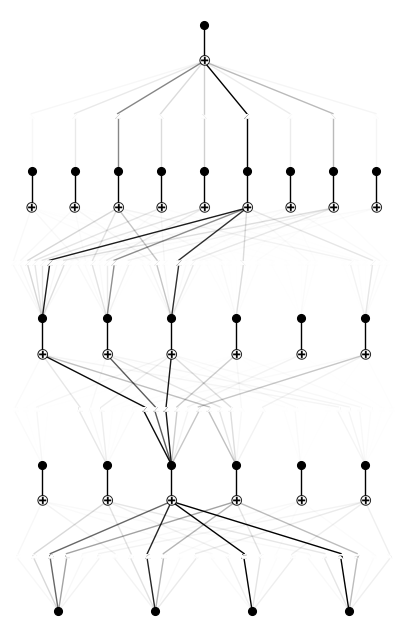

In [455]:
model.plot()

И тут я вспомнил, что вообще-то добычи должны передаваться в рассчет градиента в кубах в секунду, а не в сутки. И пересчитал все что было выше.
Теперь предлагается в исходном датасете значение выходной переменной также привести к масштабу входных. Результаты сравнить.

In [458]:
count = 9
sec_p_day = 24 * 60 * 60   

d = np.linspace(0.05, 0.5, count)
wc = np.linspace(0, 0.99, count)
delta_qg = np.linspace(0, 1000, count) / sec_p_day
q0 = np.linspace(5, 700, count) / sec_p_day


constants = {'T' : 50,
            'rho0' : 840.,
            'rhog' : 700.,
            'muo' : 0.07575,
            'epsilon' : 0.000015,
            'sigmao' : 0.02,
            'theta' : 90,
            'rs' : 20,
            'p' : 1,
            }

iters_count = count ** 4
data_dict = []
with tqdm(total=iters_count) as pbar:
    for d_i, wc_i, delta_qg_i, q0_i in itertools.product(d, wc, delta_qg, q0):
        pbar.update(1)
        mode, grav, fric, hl, ll = calc_DP_DZ(**constants, wc = wc_i, d = d_i, delta_qg = delta_qg_i, q0 = q0_i)
        if (grav > 0 and fric > 0 and hl > ll) and (mode == 0 or mode == 1):
            DP_DZ = grav + fric
            data_dict.append({'d' : d_i,
                              'wc' : wc_i,
                              'delta_qg' : delta_qg_i,
                              'q0' : q0_i,
                              'DP_DZ' : DP_DZ,
                              })
            
data = pd.DataFrame(data_dict)           
            
data['delta_qg'] = data['delta_qg'] * 1e2
data['q0'] = data['q0'] * 1e2
data['DP_DZ'] = data['DP_DZ'] * 1e-4

100%|██████████| 6561/6561 [00:01<00:00, 3757.43it/s]


In [459]:
data

,d,wc,delta_qg,q0,DP_DZ
0,0.05,0.00,0.0,0.005787,0.688421
1,0.05,0.00,0.0,0.106337,0.688416
2,0.05,0.00,0.0,0.206887,0.688411
3,0.05,0.00,0.0,0.307436,0.688406
4,0.05,0.00,0.0,0.407986,0.688401
...,...,...,...,...,...
3414,0.50,0.99,0.0,0.407986,0.978074
3415,0.50,0.99,0.0,0.508536,0.978074
3416,0.50,0.99,0.0,0.609086,0.978074
3417,0.50,0.99,0.0,0.709635,0.978074


In [460]:
torch.set_default_dtype(torch.float32)
labels_tensor = torch.tensor(np.float32(pd.DataFrame(data['DP_DZ']).values))
data_tensor = torch.tensor(np.float32(pd.DataFrame(data[['d', 'wc', 'delta_qg', 'q0']]).values))
dataset = create_dataset_from_data(data_tensor, labels_tensor)

In [461]:
model = KAN([4,8,16,16,1], grid=10, k=5, seed=0)
model.fit(dataset, steps = 20)

checkpoint directory created: ./model
saving model version 0.0


| train_loss: 7.38e-04 | test_loss: 2.12e-03 | reg: 4.84e+01 | : 100%|█| 20/20 [01:21<00:00,  4.06s/

saving model version 0.1


{'train_loss': [array(0.01403714, dtype=float32),
  array(0.00627875, dtype=float32),
  array(0.00397253, dtype=float32),
  array(0.00287588, dtype=float32),
  array(0.00215213, dtype=float32),
  array(0.00298308, dtype=float32),
  array(0.00212703, dtype=float32),
  array(0.00171506, dtype=float32),
  array(0.00140261, dtype=float32),
  array(0.00117388, dtype=float32),
  array(0.0015418, dtype=float32),
  array(0.00125278, dtype=float32),
  array(0.00109418, dtype=float32),
  array(0.00096083, dtype=float32),
  array(0.0008622, dtype=float32),
  array(0.00148136, dtype=float32),
  array(0.00114091, dtype=float32),
  array(0.00093369, dtype=float32),
  array(0.00082, dtype=float32),
  array(0.00073795, dtype=float32)],
 'test_loss': [array(0.01695597, dtype=float32),
  array(0.00900749, dtype=float32),
  array(0.00635965, dtype=float32),
  array(0.00522055, dtype=float32),
  array(0.00427402, dtype=float32),
  array(0.00431256, dtype=float32),
  array(0.00353785, dtype=float32),
  arr

In [462]:
count = 8
sec_p_day = 24 * 60 * 60   

d_ = np.linspace(0.08, 0.47, count)
wc_ = np.linspace(0.05, 0.9, count)
delta_qg_ = np.linspace(50, 950, count) / sec_p_day            
q0_ = np.linspace(50, 650, count) / sec_p_day 

constants = {'T' : 50,
            'rho0' : 840.,
            'rhog' : 700.,
            'muo' : 0.07575,
            'epsilon' : 0.000015,
            'sigmao' : 0.02,
            'theta' : 90,
            'rs' : 20,
            'p' : 1,
            }

iters_count = count ** 4
DP_DZ_dict = []
validation_data = []
with tqdm(total=iters_count) as pbar:
    for d_i, wc_i, delta_qg_i, q0_i in itertools.product(d_, wc_, delta_qg_, q0_):
        pbar.update(1)
        mode, grav, fric, hl, ll = calc_DP_DZ(**constants, wc = wc_i, d = d_i, delta_qg = delta_qg_i, q0 = q0_i)
        if (grav > 0 and fric > 0 and hl > ll) and (mode == 0 or mode == 1):
            DP_DZ = grav + fric
            DP_DZ_dict.append(DP_DZ)
            validation_data.append({'d' : d_i, 'wc' : wc_i, 'delta' : delta_qg_i * 1e2, 'q' : q0_i * 1e2})

100%|██████████| 4096/4096 [00:01<00:00, 3925.06it/s]


In [465]:
KAN_results = model(torch.tensor(np.float32(pd.DataFrame(validation_data).values))) * 1e4
skm.mean_absolute_percentage_error(DP_DZ_dict, KAN_results.tolist())

0.021255244720412857

А вот это, скажу я вам, — совершенно другое дело!

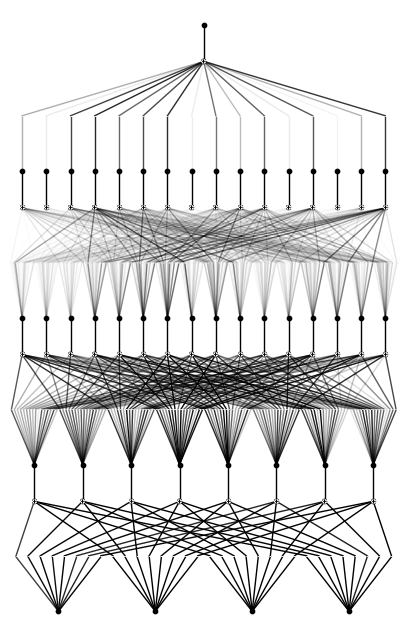

In [466]:
model.plot()

In [467]:
model = model.prune_node(threshold=1e-2)
KAN_results = model(torch.tensor(np.float32(pd.DataFrame(validation_data).values))) * 1e4
skm.mean_absolute_percentage_error(DP_DZ_dict, KAN_results.tolist())

saving model version 0.2


0.021255244720412857

Совершенно очевидно, что такой экспоненциальный рост времени расчета с Nпеременных мой i9 9880h вывозит с большим трудом. Однако, мы уже протестили модель и при N = 2 и при N = 4.
Давайте же, вооружившись этим знанием, попробуем вернуться к исходной задаче.

In [488]:
count = 7
sec_p_day = 24 * 60 * 60   


# Чтобы избежать датасета размером в 100+ ярдов строк,
# здесь я позволю себе зафиксировать только плотности нефти и газа, а также к-т поверх. наятж-я нефти
# т.к. они меняется в незначительных пределах:
rho0 = 850
rhog = 1000
sigmao = 20 * 1e-3

T = np.linspace(10, 100, count)                         #температура гр.Ц.
d = np.linspace(0.05, 0.5, count)                       #диаметры труб
theta = np.linspace(10, 90, count)                      #уголы наклона
q0 = np.linspace(5, 1000, count) / sec_p_day            #дебит нефти п.у. м**3/с
delta_qg = np.linspace(0, 1000, count) / sec_p_day      #дельта к дебиту нефти, чтобы не получить отрицательные значения по расходу газа (для корректного рассчета коррелляции)
rs = np.linspace(5, 40, count)                          #коэффициент растворимости газа в нефти (конденсации) или коэффициент выделения газа из нефти (выкипания)
muo = np.linspace(1.5 * 1e-3, 150 * 1e-3, count)        #вязкость нефти
epsilon = np.linspace(15 * 1e-6, 300 * 1e-6, count)     #шероховатость стенки трубы
wc = np.linspace(0, 0.99, count)                        #коэффициент обводненности
p = np.linspace(10, 100, count)

N_var = 9 #число переменных

In [489]:
data_dict = []
data_fp_2_3_dict = []
with tqdm(total = count ** N_var) as pbar:
    for T_i, d_i, theta_i, q0_i, delta_qg_i, rs_i, muo_i, epsilon_i, wc_i in itertools.product(T, d, theta, q0, delta_qg, rs, muo, epsilon, wc):
        pbar.update(1)
        mode, grav, fric, hl, ll = calc_DP_DZ(T = T_i, d = d_i, theta = theta_i, q0 = q0_i, delta_qg = delta_qg_i, rs = rs_i, muo = muo_i, epsilon = epsilon_i, wc = wc_i, p = 1, rho0 = 850, rhog = 1000, sigmao = 20 * 1e-3)
        if (grav > 0 and fric > 0 and hl > ll) and (mode == 0 or mode == 1):
            DP_DZ = grav + fric
            data_dict.append({'T' : T_i, 
                              'd' : d_i,
                              'theta' : theta_i,
                              'q0' : q0_i,
                              'delta_qg' : delta_qg_i,
                              'rs' : rs_i,
                              'muo' : muo_i,
                              'epsilon' : epsilon_i,
                              'wc' : wc_i,
                              'DP_DZ' : DP_DZ,
                              })
        elif (grav > 0 and fric > 0 and hl > ll) and (mode == 2 or mode == 3):
            for p_i in p:
                mode, grav, fric, hl, ll = calc_DP_DZ(T = T_i, d = d_i, theta = theta_i, q0 = q0_i, delta_qg = delta_qg_i, rs = rs_i, muo = muo_i, epsilon = epsilon_i, wc = wc_i, p = p_i, rho0 = 850, rhog = 1000, sigmao = 20 * 1e-3)
                DP_DZ = grav + fric
                data_fp_2_3_dict.append({'T' : T_i, 
                                        'd' : d_i,
                                        'theta' : theta_i,
                                        'q0' : q0_i,
                                        'delta_qg' : delta_qg_i,
                                        'rs' : rs_i,
                                        'muo' : muo_i,
                                        'epsilon' : epsilon_i,
                                        'wc' : wc_i,
                                        'p' : p_i,                                        
                                        'DP_DZ' : DP_DZ,
                                        })

100%|██████████| 40353607/40353607 [2:34:07<00:00, 4363.71it/s]  


In [490]:
data = pd.DataFrame(data_dict)
data.to_csv('data.csv')

Ну вот мы и стали обладателями скромного датасета объемом 3.5 Гб

In [3]:
data = pd.read_csv('data.csv')
data.drop('Unnamed: 0', axis=1, inplace = True)

In [5]:
data

,T,d,theta,q0,delta_qg,rs,muo,epsilon,wc,DP_DZ
0,10.0,0.05,10.0,0.000058,0.000000,5.0,0.0015,0.000015,0.000,1209.661833
1,10.0,0.05,10.0,0.000058,0.000000,5.0,0.0015,0.000015,0.165,1291.143266
2,10.0,0.05,10.0,0.000058,0.000000,5.0,0.0015,0.000015,0.330,1372.624693
3,10.0,0.05,10.0,0.000058,0.000000,5.0,0.0015,0.000015,0.495,1454.106116
4,10.0,0.05,10.0,0.000058,0.000000,5.0,0.0015,0.000015,0.660,1535.587535
...,...,...,...,...,...,...,...,...,...,...
25194178,100.0,0.50,90.0,0.011574,0.011574,40.0,0.1500,0.000252,0.165,7435.361941
25194179,100.0,0.50,90.0,0.011574,0.011574,40.0,0.1500,0.000252,0.330,7904.596839
25194180,100.0,0.50,90.0,0.011574,0.011574,40.0,0.1500,0.000300,0.000,6966.126136
25194181,100.0,0.50,90.0,0.011574,0.011574,40.0,0.1500,0.000300,0.165,7435.361941


In [6]:
data.info(show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25194183 entries, 0 to 25194182
Data columns (total 10 columns):
 #   Column    Non-Null Count     Dtype  
---  ------    --------------     -----  
 0   T         25194183 non-null  float64
 1   d         25194183 non-null  float64
 2   theta     25194183 non-null  float64
 3   q0        25194183 non-null  float64
 4   delta_qg  25194183 non-null  float64
 5   rs        25194183 non-null  float64
 6   muo       25194183 non-null  float64
 7   epsilon   25194183 non-null  float64
 8   wc        25194183 non-null  float64
 9   DP_DZ     25194183 non-null  float64
dtypes: float64(10)
memory usage: 1.9 GB


In [7]:
data.max()

T            100.000000
d              0.500000
theta         90.000000
q0             0.011574
delta_qg       0.011574
rs            40.000000
muo            0.150000
epsilon        0.000300
wc             0.990000
DP_DZ       9781.561654
dtype: float64

Сделаем нормализацию через матрицу

In [4]:
normalization_matrix = np.diag([1e-2, 1, 1e-2, 1e2, 1e2, 1e-2, 1e1, 1e3, 1, 1e-4])

In [5]:
mult = data.values @ normalization_matrix

In [6]:
mult = pd.DataFrame(mult, columns = ['T','d','theta','q0','delta_qg','rs','muo','epsilon','wc','DP_DZ'])

In [ ]:
torch.set_default_dtype(torch.float32)
labels_tensor = torch.tensor(np.float32(mult['DP_DZ'].values))
data_tensor = torch.tensor(np.float32(mult[['T','d','theta','q0','delta_qg','rs','muo','epsilon','wc']].values))
dataset = create_dataset_from_data(data_tensor, labels_tensor)

In [ ]:
model = KAN([9,18,48,48,48,1], grid=10, k=5, seed=0)
model.fit(dataset, steps = 20)

checkpoint directory created: ./model
saving model version 0.0


description:   0%|                                                           | 0/20 [00:00<?, ?it/s]

К сожалению на моем макбуке уже с таким датасетом ядро пайтон стабильно умирает. 
Попробую перенести задачу на стационарный комп с rtx3060 и запустить решатель на cuda.

Давайте теперь попробуем все то же самое, но с MLP.
Вооружившись опытом KAN, также будем брать 3 внутренних слоя и гладкие функции активации. 
Есть гипотеза, что вид функции активации будет решать для этой конкретной задачи.

In [ ]:
class MyNN(nn.Module):
    def __init__(self, n_variables = W):
        # super позволяеть наследовать методы модуля nn
        super(MyNN,self).__init__()
        # создаем линейный слой
        N = n_variables * (2 * n_variables + 1)
        self.linear1 = nn.Linear(n_variables, N)
        self.linear2 = nn.Linear(N,n_variables)
        self.linear3 = nn.Linear(n_variables,n_variables)
        self.linear4 = nn.Linear(n_variables,1)

    def forward(self, x):
        x = F.sigmoid(self.linear1(x))
        x = F.sigmoid(self.linear2(x))
        x = F.sigmoid(self.linear3(x))
        x = self.linear4(x)
        return x
    
model = MyNN()
# инициализируем Adam для накопления импульса во время спуска
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.001)

In [ ]:
N_EPOCHS = 150

train_loss_history = []
dev_loss_history = []
ce = nn.CrossEntropyLoss()

# Пройдемся 501 эпоху
for i in tqdm(range(N_EPOCHS)):
    # Прямой проход (предсказания)
    predictions = model(tensor_data)
    # Функция потерь
    loss = ce(predictions, tensor_labels) # активация уже включена
    # Градиенты
    optimizer.zero_grad()
    loss.backward()
    # Шаг спуска
    optimizer.step()
    train_loss_history.append(loss.item())

    # Валидируемся
    if i % 10 == 0:
        predictions = model(X_dev)
        loss = ce(predictions, y_dev)
        dev_loss_history.append(loss.item())